## Tesla's stock return prediction with LSTM

In [106]:
import torch
from torch import nn, optim
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Load in the data

In [107]:
series = pd.read_csv("TESLA.csv", usecols=range(1, 7))

In [108]:
# Create a new column indicating whether the stock is increasing or decreasing
series["Adj Close Future"] = series.shift(1)["Adj Close"]
targets = (series["Adj Close Future"] > series["Adj Close"]).astype(np.int8).to_numpy(np.int8)

In [109]:
series = series.to_numpy()
series.shape, targets.shape

((253, 7), (253,))

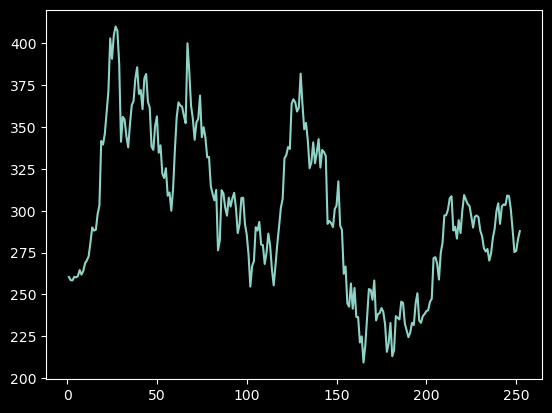

In [110]:
plt.plot(series[:, -1])
plt.show()

In [111]:
# Normalize the dataset
N_train = 2 * len(series) // 3
T = 15
scaler = StandardScaler()
scaler.fit(series[:N_train + T - 1])
series = scaler.transform(series)

In [112]:
# Create the dataset
D = series.shape[-1] - 1
X = []
Y = []

for t in range(len(series)-T):
    X.append(series[t:t+T, :-1])  # Not include the last column
    Y.append(targets[t+T]) 

# Convert to arrays
X = np.array(X).reshape(len(X), T, D)
Y = np.array(Y).reshape(-1, 1)

In [113]:
N = X.shape[0]
X.shape, Y.shape

((238, 15, 6), (238, 1))

In [114]:
# Spilt the dataset
X_train = torch.from_numpy(X[:N_train].astype(np.float32))
X_test = torch.from_numpy(X[N_train:].astype(np.float32))
y_train = torch.from_numpy(Y[:N_train].astype(np.float32))
y_test = torch.from_numpy(Y[N_train:].astype(np.float32))

In [115]:
X_train.shape, X_test.shape

(torch.Size([168, 15, 6]), torch.Size([70, 15, 6]))

## Build the model

In [116]:
class LSTM_RNN(nn.Module):
    def __init__(self, num_inputs, num_outs, num_hiddens, num_layers):
        super(LSTM_RNN, self).__init__()
        
        self.L = num_layers
        self.D = num_inputs
        self.K = num_outs
        self.M = num_hiddens
        
        # LSTM layers
        self.rnn = nn.LSTM(
            input_size=self.D,
            hidden_size=self.M,
            num_layers=self.L,
            batch_first=True
        )
        
        # Dense layer
        self.dense = nn.Linear(self.M, self.K)
    
    def forward(self, X):
        h0 = torch.zeros(self.L, X.size(0), self.M)
        c0 = torch.zeros(self.L, X.size(0), self.M)
        
        out, _ = self.rnn(X, (h0, c0))
        
        out = self.dense(out[:, -1, :])
        return out

In [117]:
def configure(model: nn.Module, lr:float, optim_method: str):
    criterion = nn.BCEWithLogitsLoss()
    if optim_method == "adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer =  optim.SGD(model.parameters(), lr=lr)
    return criterion, optimizer

In [118]:
def full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, num_epochs):
    loss_history, test_history = np.zeros(num_epochs), np.zeros(num_epochs)
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        # Training
        outs = model(X_train)
        loss = criterion(outs, y_train)
        loss_history[epoch] = loss.item()
        loss.backward()
        optimizer.step()
        
        # Validating
        test_outs = model(X_test)
        test_loss = criterion(test_outs, y_test.view(-1, 1))
        test_history[epoch] = test_loss.item()
    
    return loss_history, test_history

## Train the model

In [119]:
model = LSTM_RNN(D, 1, 10, 3)
criterion, optimizer = configure(model, 0.01, "adam")

In [120]:
train_loss, test_loss = full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test, 500)

## Plot the loss

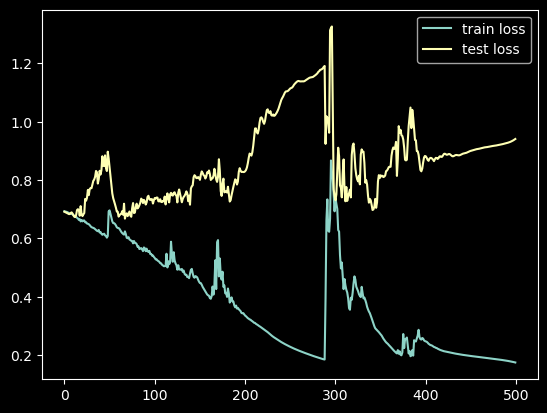

In [121]:
plt.plot(train_loss, label="train loss")
plt.plot(test_loss, label="test loss")
plt.legend()
plt.show()

Clearly, the model is overfitting.

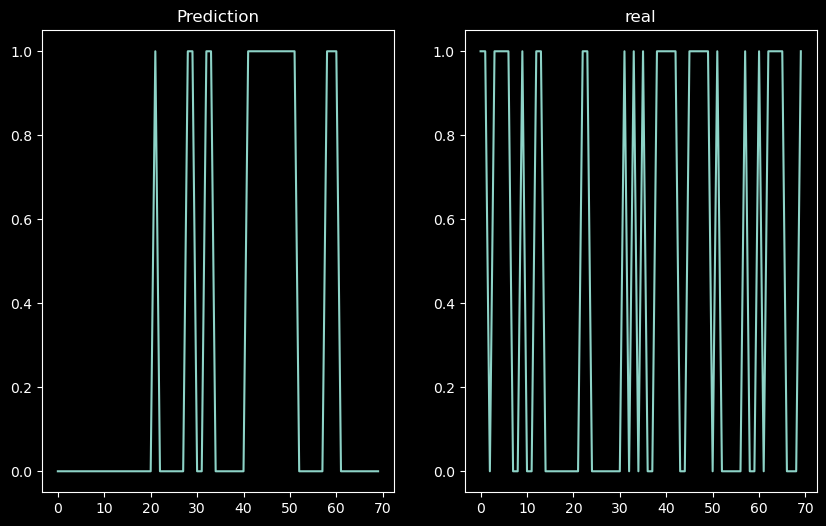

In [129]:
# One step prediction
plt.figure(figsize=(10, 6))
outs = model(X_test).detach()
plt.subplot(1, 2, 1)
plt.title("Prediction")
plt.plot((nn.Sigmoid()(outs) >= 0.5), label="prediction")
plt.subplot(1, 2, 2)
plt.title("real")
plt.plot(y_test, label="real")
plt.show()

In general, the model picks up some general trends, but after all, the model is still pretty bad.

In [135]:
# Accuracy for one step forecast
(((nn.Sigmoid()(outs) >= 0.5) == y_test).sum() / y_test.size(0)).item()

0.4571428596973419